# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
import random

# Load the Dataset

In [2]:
sales_df = pd.read_csv("/content/drive/MyDrive/rkmveri/Data.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/rkmveri/Submission Format.csv")
sales_df.head()

,Warehouse id,Region,SKU id,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,...,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,May-21
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24


# Visualisation and EDA

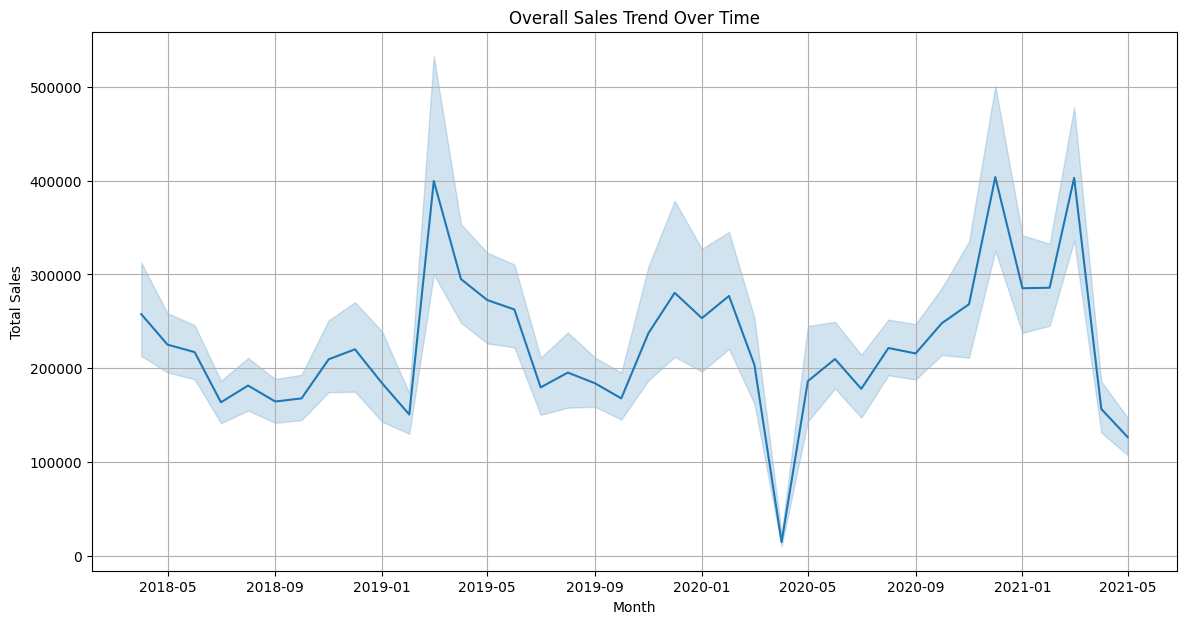

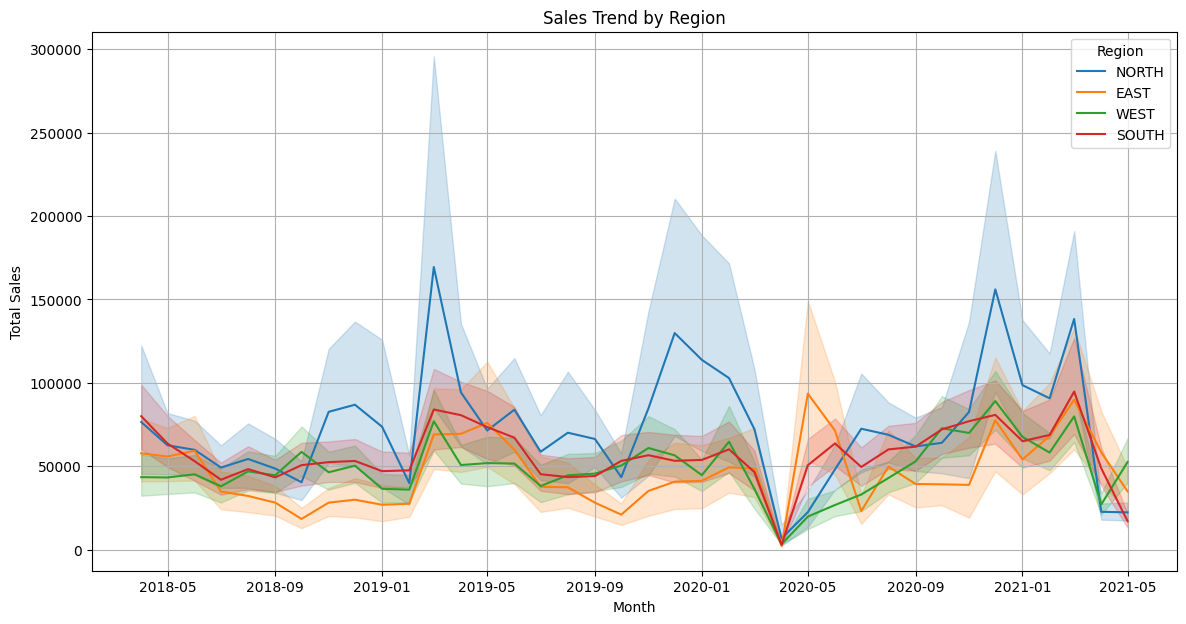

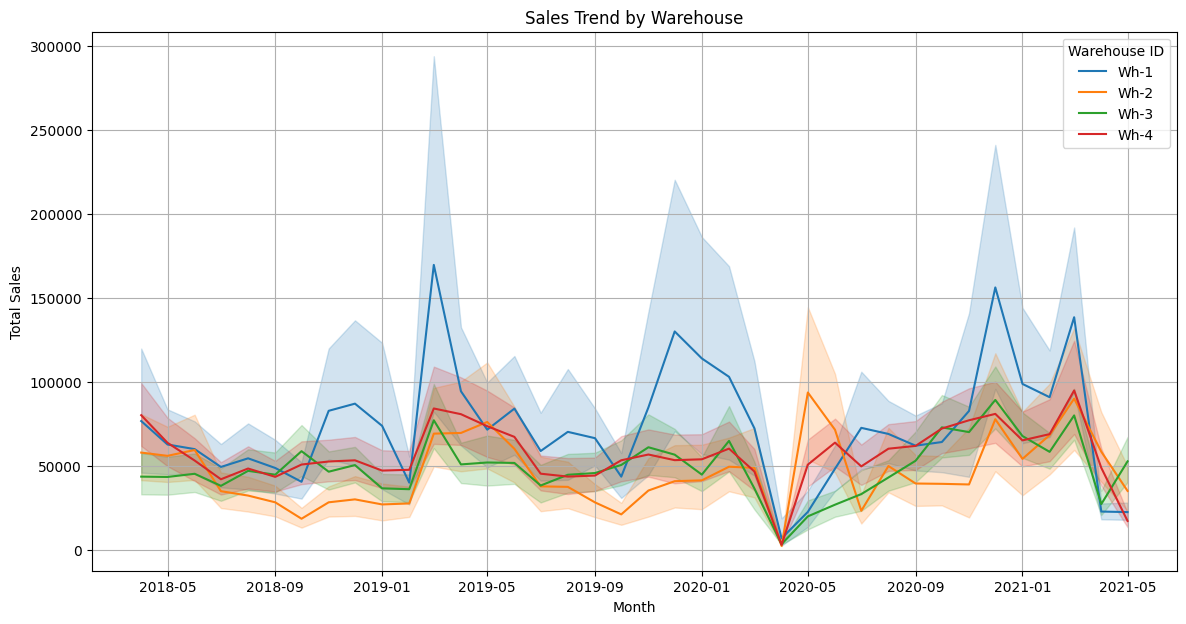

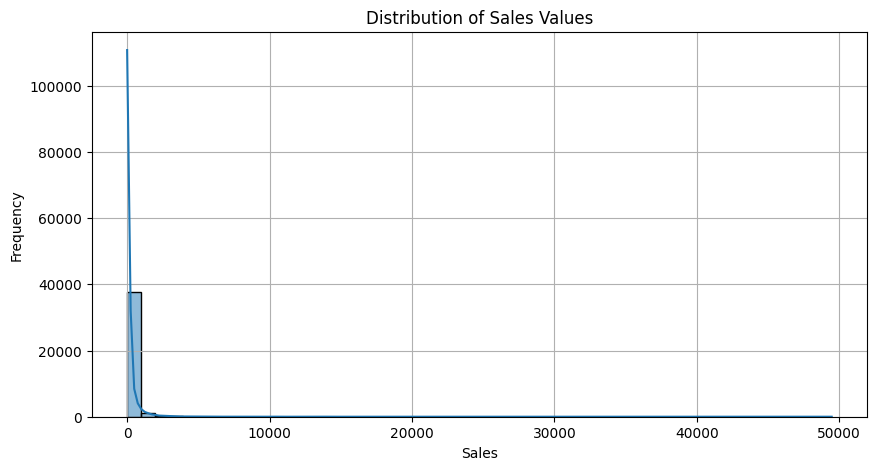

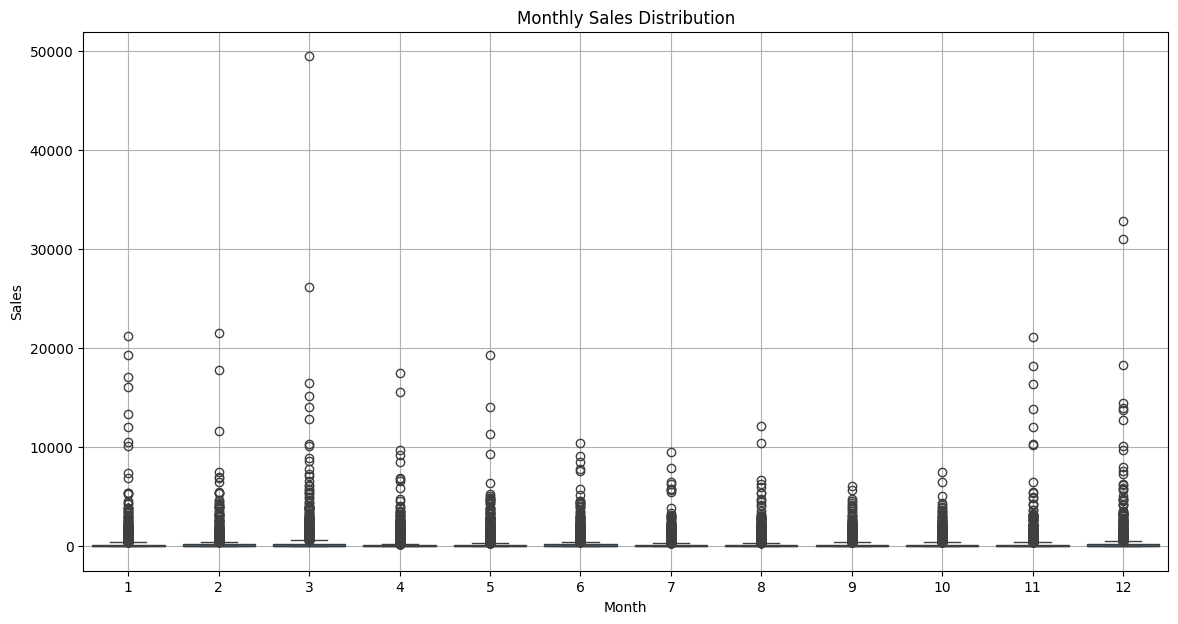

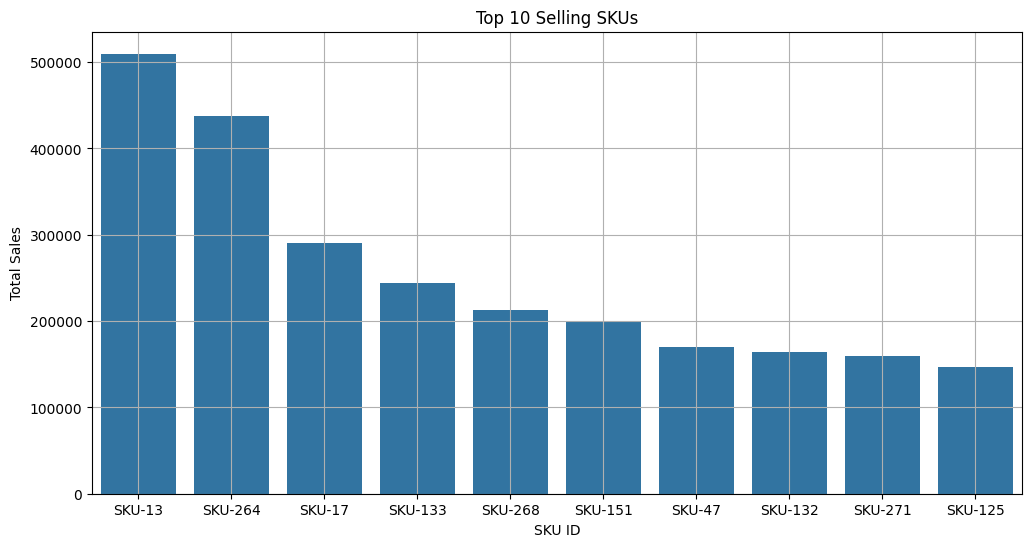

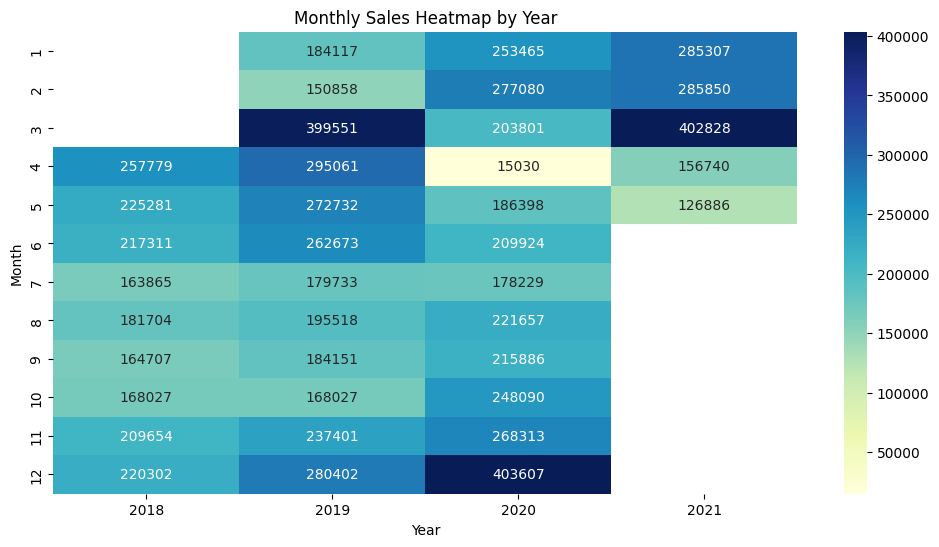

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sales_df = pd.read_csv("/content/drive/MyDrive/rkmveri/Data.csv")

id_vars = ['Warehouse id', 'Region', 'SKU id']
sales_df_melted = sales_df.melt(id_vars=id_vars, var_name='Month', value_name='Sales')

sales_df_melted['Month'] = pd.to_datetime(sales_df_melted['Month'], format='%b-%y')

sales_df_melted['Sales'] = pd.to_numeric(sales_df_melted['Sales'], errors='coerce')

# Fill NaN values with 0 (assuming missing sales data means no sales)
sales_df_melted['Sales'] = sales_df_melted['Sales'].fillna(0)


# 1. Overall Sales Trend
plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='Sales', data=sales_df_melted, estimator=sum)
plt.title('Overall Sales Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# 2. Sales by Region
plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='Sales', hue='Region', data=sales_df_melted, estimator='sum')
plt.title('Sales Trend by Region')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Region')
plt.grid(True)
plt.show()

# 3. Sales by Warehouse
plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='Sales', hue='Warehouse id', data=sales_df_melted, estimator='sum')
plt.title('Sales Trend by Warehouse')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Warehouse ID')
plt.grid(True)
plt.show()

# 4. Distribution of Sales (Histogram)
plt.figure(figsize=(10, 5))
sns.histplot(sales_df_melted['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales Values')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 5. Box Plot of Sales by Month
plt.figure(figsize=(14, 7))
sns.boxplot(x=sales_df_melted['Month'].dt.month, y='Sales', data=sales_df_melted)
plt.title('Monthly Sales Distribution')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# 6. Top 10 Selling SKUs
top_skus = sales_df_melted.groupby('SKU id')['Sales'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_skus.index, y=top_skus.values)
plt.title('Top 10 Selling SKUs')
plt.xlabel('SKU ID')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# 7. Sales by Year and Month (Heatmap)
sales_pivot = sales_df_melted.pivot_table(values='Sales', index=sales_df_melted['Month'].dt.month, columns=sales_df_melted['Month'].dt.year, aggfunc='sum')
plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Monthly Sales Heatmap by Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

# Melt the Sales Data

In [6]:
id_vars = ['Warehouse id', 'Region', 'SKU id']
sales_df_melted = sales_df.melt(id_vars=id_vars, var_name='Month', value_name='Sales')
sales_df_melted['Month'] = pd.to_datetime(sales_df_melted['Month'], format='%b-%y')

sales_df_melted.head()

,Warehouse id,Region,SKU id,Month,Sales
0,Wh-1,NORTH,SKU-1,2018-04-01,27
1,Wh-1,NORTH,SKU-2,2018-04-01,88
2,Wh-1,NORTH,SKU-3,2018-04-01,6
3,Wh-1,NORTH,SKU-4,2018-04-01,162
4,Wh-1,NORTH,SKU-5,2018-04-01,171


# Convert Sales to Numeric and Handle Missing Values

In [7]:
sales_df_melted['Sales'] = pd.to_numeric(sales_df_melted['Sales'], errors='coerce')
sales_df_melted['Sales'] = sales_df_melted['Sales'].fillna(0)

# Calculate Monthly, Yearly, and Rolling Averages

In [8]:
sales_df_melted['year'] = sales_df_melted['Month'].dt.year
sales_df_melted['month'] = sales_df_melted['Month'].dt.month

# Calculate monthly average
monthly_avg = sales_df_melted.groupby(['Warehouse id', 'Region', 'SKU id', 'month'])['Sales'].mean().reset_index()
monthly_avg.rename(columns={'Sales': 'monthly_avg'}, inplace=True)
sales_df_melted = pd.merge(sales_df_melted, monthly_avg, on=['Warehouse id', 'Region', 'SKU id', 'month'], how='left')

# Calculate yearly average
yearly_avg = sales_df_melted.groupby(['Warehouse id', 'Region', 'SKU id', 'year'])['Sales'].mean().reset_index()
yearly_avg.rename(columns={'Sales': 'yearly_avg'}, inplace=True)
sales_df_melted = pd.merge(sales_df_melted, yearly_avg, on=['Warehouse id', 'Region', 'SKU id', 'year'], how='left')

# Calculate 12-month rolling average
sales_df_melted['rolling_avg'] = sales_df_melted.groupby(['Warehouse id', 'Region', 'SKU id'])['Sales'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Create External Data (Holidays and Promotions)

In [10]:

def create_dummy_holidays(start_date, end_date):
  dates = pd.date_range(start=start_date, end=end_date, freq='MS')
  holidays = []
  for date in dates:
    if date.month == 1:
      holidays.append(date)
    elif date.month == 7:
      holidays.append(date)
  return holidays

holidays = create_dummy_holidays(sales_df_melted['Month'].min(), sales_df_melted['Month'].max() +  pd.DateOffset(years=1))

def create_dummy_promotions(df, start_date, end_date):
  dates = pd.date_range(start=start_date, end=end_date, freq='MS')
  promo_data = {}
  for warehouse, region, sku in df[['Warehouse id','Region','SKU id']].drop_duplicates().values:
        for date in dates:
            promo_data[(warehouse,region,sku,date)] = random.choice([0,1]) # Add random promotion data
  return promo_data

promo_data = create_dummy_promotions(sales_df_melted, sales_df_melted['Month'].min(), sales_df_melted['Month'].max() +  pd.DateOffset(years=1))

 # Feature Engineering

In [11]:
sales_df_melted['is_holiday'] = sales_df_melted['Month'].isin(holidays).astype(int)
sales_df_melted['is_promotion'] = sales_df_melted.apply(lambda x: promo_data[(x['Warehouse id'],x['Region'],x['SKU id'],x['Month'])],axis=1)
sales_df_melted['lagged_sales'] = sales_df_melted.groupby(['Warehouse id', 'Region', 'SKU id'])['Sales'].shift(12)
sales_df_melted['lagged_sales'] = sales_df_melted['lagged_sales'].fillna(0)

# Forecasting using Prophet

In [12]:
def forecast_prophet(df):
    """Forecasts June 2021 sales for each group using Prophet."""
    june_2021_predictions = []
    for group_name, group_data in df.groupby(['Warehouse id', 'Region', 'SKU id']):
        try:
            prophet_df = group_data[['Month', 'Sales']].rename(columns={'Month': 'ds', 'Sales': 'y'})

            model = Prophet()
            model.fit(prophet_df)

            future_date = group_data['Month'].max() + pd.DateOffset(months=1)
            future = pd.DataFrame({'ds': [future_date]})

            forecast = model.predict(future)
            june_2021_predictions.append({'Warehouse id': group_name[0],
                                          'Region': group_name[1],
                                          'SKU id': group_name[2],
                                          'June-21': forecast['yhat'].values[0]})
        except Exception as e:
             print(f"Error with SKU {group_name} : {e}, using fallback average")
             june_2021_predictions.append({'Warehouse id': group_name[0], 'Region': group_name[1], 'SKU id': group_name[2], 'June-21': group_data['Sales'].tail(3).mean()})

    return pd.DataFrame(june_2021_predictions)

june_2021_forecast_prophet = forecast_prophet(sales_df_melted)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp1ae6zz1/gcb0tu2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp1ae6zz1/fmuxy099.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38436', 'data', 'file=/tmp/tmpp1ae6zz1/gcb0tu2x.json', 'init=/tmp/tmpp1ae6zz1/fmuxy099.json', 'output', 'file=/tmp/tmpp1ae6zz1/prophet_modelwg1zf6j0/prophet_model-20250107135010.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:50:10 - cmdstanpy - INFO - Chain [1] start

# Prepare Submission File

In [17]:
submission_df = pd.merge(submission_df, june_2021_forecast_prophet[['Warehouse id', 'Region', 'SKU id','June-21']],
                             on=['Warehouse id', 'Region', 'SKU id'], how='left')

submission_df['June-21'] = submission_df['June-21'].fillna(0)
submission_df['June-21'] = submission_df['June-21']

# Generate Submission File

In [15]:
submission_df.to_csv("/content/drive/MyDrive/rkmveri/Shuvam_Podder.csv",index=False)
print("submission file prophet created")

print(submission_df.head())

submission file prophet created
  Warehouse id Region SKU id  Jun-21      June-21
0         Wh-1  NORTH  SKU-1     NaN    12.126069
1         Wh-1  NORTH  SKU-2     NaN    68.635755
2         Wh-1  NORTH  SKU-3     NaN    11.755795
3         Wh-1  NORTH  SKU-4     NaN   223.432986
4         Wh-1  NORTH  SKU-5     NaN  1270.713136
